# Predicting the Landing Likelyhood of a Space X Launch
# **SpaceX  Falcon 9 first stage Landing Prediction**

In this project I develop a Machine Learning model to predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch.

![](https://media4.giphy.com/media/3ohs4gSs3V0Q7qOtKU/giphy.gif?cid=790b7611f51f089f4244951ec28b4ea678954df000f48c94&rid=giphy.gif)

## Table of Contents
- [Data Acquisition](#data_acquisition)
- [Data Pre-Processing](#data_preprocessing)
- [Exploratory Data Analysis](#eda)
- [Model Development](#model-development)
- [Conclusions](#conclusions)

# <a name="data_acquisition"> Data Acquisition </a>
For this application the data is gathered from the SpaceX REST API. This API will provide data about launches including:
- information about the rocket used
- payload delivered
- launch specifications
- landing specifications
- landing outcome

The data will be obtained in a JSON object. Specifically I will get a list of JSON objects which each represent a launch.

## Import Libraries

In [1]:
# import the required libraries

import requests
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")

# print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# print all of the data in a feature
pd.set_option('display.max_colwidth', None)

## Request and Parse Space X Launch Data
I will use th GET request to request and parse the dataset containing the launch infromation.

In [2]:
# define url
spacex_url="https://api.spacexdata.com/v4/launches/past"
# get request
response = requests.get(spacex_url)

Verify that the request was successfull. The status response code should be 200 if the get request was successfull.

In [3]:
print(response.status_code)

200


Store the request content in a Pandas dataframe

In [4]:
data = pd.json_normalize(response.json())

Get dataframe information and a preview.

In [5]:
print('Initial dataframe shape: ', data.shape)
data.head()

Initial dataframe shape:  (143, 43)


,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/3d/86/cnu0pan8_o.png,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': 

The above dataframe contains IDs for many columns. I will perform other API requests in order to get information about the launches.

### Define Functions for API Requests
In this section I will define auxiliary functions that retrieve readable data from the columns of the above dataframe.

In particular:
- form the <code>rocket</code> column I want to get the booster name
- form the <code>launchpad</code> column I want to get the the launch site and it's coordinates
- form the <code>payload</code> column I want to get the mass of the payload and its orbit
- form the <code>cores</code> column I want to get the outcome of the landing, number of flight with that core, whether grindfins were used, whether the core was reused, whether legs were reused, the landing pad used, the block of the core, how many times the core has been reused, the serial of the core

In [6]:
#define url of needed tables
rockets_url = "https://api.spacexdata.com/v4/rockets/"
launchpads_url = "https://api.spacexdata.com/v4/launchpads/"
payloads_url = "https://api.spacexdata.com/v4/payloads/"
cores_url = "https://api.spacexdata.com/v4/cores/"

In [7]:
# takes the dataset and uses the rocket column to call the API and append the data to the list BoosterVersion
def getBoosterVersion(data):
    for x in data['rocket']:
        response = requests.get(rockets_url+str(x)).json()
        BoosterVersion.append(response['name'])

In [8]:
# takes the dataset and uses the launchpad column to call the API and append the data to the list LaunchSite
def getLaunchSite(data):
    for x in data['launchpad']:
        response = requests.get(launchpads_url+str(x)).json()
        Longitude.append(response['longitude'])
        Latitude.append(response['latitude'])
        LaunchSite.append(response['name'])

In [9]:
# takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
        response = requests.get(payloads_url+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

In [10]:
# takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get(cores_url+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

## Create the Dataframe

In [11]:
# take a subset of the dataframe
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# remove rows with multiple cores
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# since payloads and cores are lists of size 1, extract the single value in the list and replace the feature
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]


In [12]:
# define global variables
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [13]:
# populate global variables with the above defined functions
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

In [14]:
# create dictionary to construct the dataset
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [15]:
# create the dataframe from the dictionary
data = pd.DataFrame(launch_dict)

In [16]:
# show the first 5 rows of the dataframe
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


## Filter results
Here I proceed filtering the results in order to isolate the Falcon 9 launches.

In [17]:
# count the occurences on 'BoosterVersion' column
data['BoosterVersion'].value_counts()

Falcon 9    90
Falcon 1     4
Name: BoosterVersion, dtype: int64

In [18]:
# filter from Falcon 9 launches
df = data[data['BoosterVersion']!='Falcon 1']
df.shape
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


# Data Preprocessing
In this section I will:
- identify with missing values
- substitute missing values when possible

Verify which columns are missing some values.

In [19]:
# display the count of missing values
df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Since the <code>PyloadMass</code> column is missing a small portion of the data, I can replace the missing values with the mean value of the feature.

In [20]:
# calculate the mean value of PayloadMass column
avg_payload_mass = df['PayloadMass'].astype(float).mean(axis=0)

# replace the np.nan values with its mean value
df['PayloadMass'].replace(np.nan, avg_payload_mass, inplace=True)

# Exploratory Data Analysis

Identify the percentage of missing values.

In [21]:
df.isnull().sum()/df.count()*100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

Identify the categorical and numerical features.

In [22]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

### Calculate the number of launches on each site
The dataset contains launches performed from different sites:
- **CCAFS SLC 40**: Cape Canaveral Space Launch Complex
- **VAFB SLC 4E** Vandenberg Air Force Base Space Launch Complex 4E
- **KSC LC 39A** Kennedy Space Center Launch Complex 39A

In [23]:
# aply value_counts() on column LaunchSite
df['LaunchSite'].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

### Calculate the number of launches on each site
The dataset contains launches aiming to dedicated orbits:
- **GTO** Geostationary Transfer Orbit
- **ISS** International Space Station Orbit
- **VLEO** Very Low Earth Orbit
- **PO** Polar Orbit
- **LEO** Low Earth Orbit
- **SSO** Sun-Synchronous Orbit
- **MEO** Medium Earth Orbit
- **SO** Sun-Synchronous Orbit
- **ES-L1** Sun-Earth Lagrange Orbit L1
- **HEO** Highly Elliptical Orbit
- **GEO** Geosynchronous Equatorial Orbit

In [24]:
# apply value_counts on Orbit column
df['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

### Create a landing outcome label
The dataset doesn't store the landing outcome in a binary form. Instead, it stores the langing outcome in a string where the fisrt word states if the mission was successfull or not (<code>True</code> for successfull missions and <code>False</code> or <code>None</code> for unsuccessfull landings) and the second word stating the type of landing pad (<code>Ocean</code>, <code>RTLS</code> or <code>ASDS</code>).

In [25]:
# count values for landing outcomes
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

The task is to store the landing outcomes in a binary variable, that assumes the value:
- 1 for successfull landings
- 0 for unsuccessfull landings

In [26]:
# define bad outcomes set
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [27]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = []
for i,outcome in df['Outcome'].items():
    if outcome in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

In [28]:
# create varaible "Class" in the dataframe
df['Class']=landing_class
df[['Class']].head()

,Class
4,0
5,0
6,0
7,0
8,0


### Compute average success rate for landings

Overall landing success rate:

In [29]:
df["Class"].mean()

0.6666666666666666

Landing success rate by launching site:

In [30]:
grouped_by_site = df.groupby("LaunchSite")
mean_by_site = grouped_by_site.mean()
mean_by_site["Class"]

LaunchSite
CCSFS SLC 40    0.600000
KSC LC 39A      0.772727
VAFB SLC 4E     0.769231
Name: Class, dtype: float64

I see that the overall success rate for Flacon 9 launches is 67%, but there are apparently sensible differences between the success rates of different launching sites. 
Cape Canaveral Space Launch Complex has a lower success rate (60%) with respet to the two other launching sites.

## EDA with Visualization

### Visualize the relationship between Flight Number and Launch Site
I use a scatter plot with a hue parameter set to the target variable <code>Class</code>.

In [31]:
# import required libraries
import seaborn as sns
import matplotlib.pyplot as plt

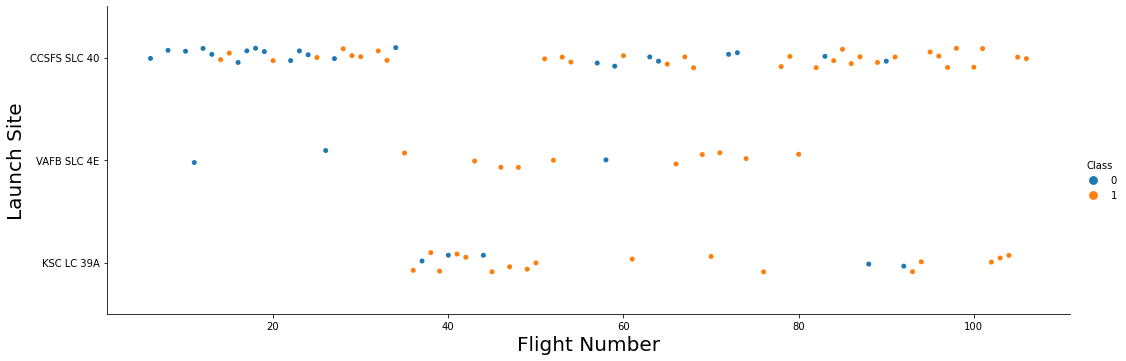

In [32]:
# scatter point chart with x axis to be Flight Number and y axis to be the launch site, and hue to be the class value
sns.catplot(y='LaunchSite', x='FlightNumber', hue='Class', data=df, aspect=3)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

From the plot above I can graphically understand that:
- VAFB SLC 4E and KSC LC 39A have an higher success rate than CCSFS SLC 40
- Success rate increases for higher FlightNumber values (i.e. most recent flights)

### Visualize the relationship between Launch Site and Payload Mass

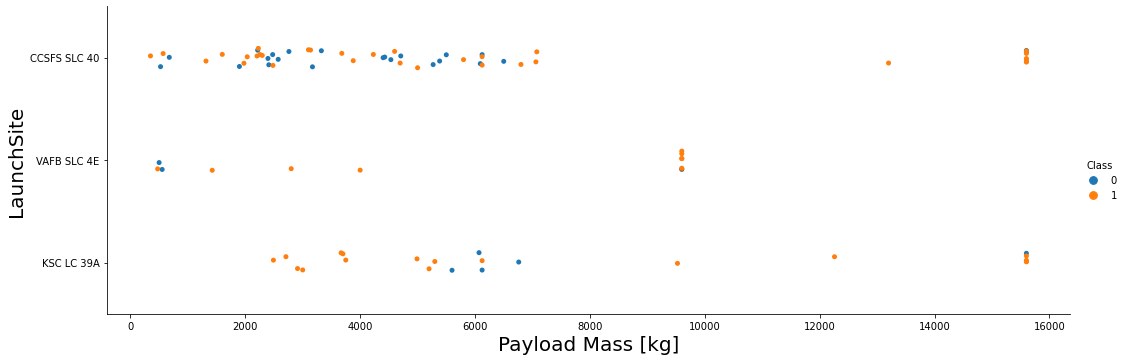

In [33]:
# scatter point chart with x axis to be Flight Number and y axis to be the launch site, and hue to be the class value
sns.catplot(x='PayloadMass', y='LaunchSite', hue='Class', data=df, aspect=3)
plt.xlabel("Payload Mass [kg]",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

The above plot shows how for the VAFB-SLC 4E launchsite there are no rockets launched for heavypayload mass (greater than 10,000 kg).

### Visualize the relationship between success rate of each orbit type

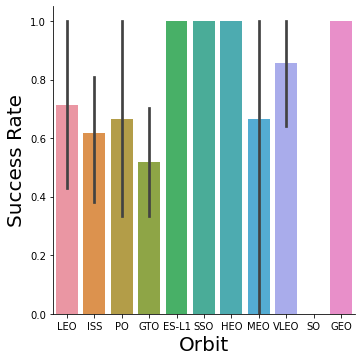

In [34]:
# barchart of different orbits success rates
sns.catplot(x="Orbit",y="Class", kind="bar",data=df)
plt.xlabel("Orbit",fontsize=20)
plt.ylabel("Success Rate",fontsize=20)
plt.show()

Orbits ES-L1, SSO, HEO and GEO have the higher success rate, on the contrary, GTO orbit has the lower success rate.

### Visualize the relationship between FlightNumber and Orbit type

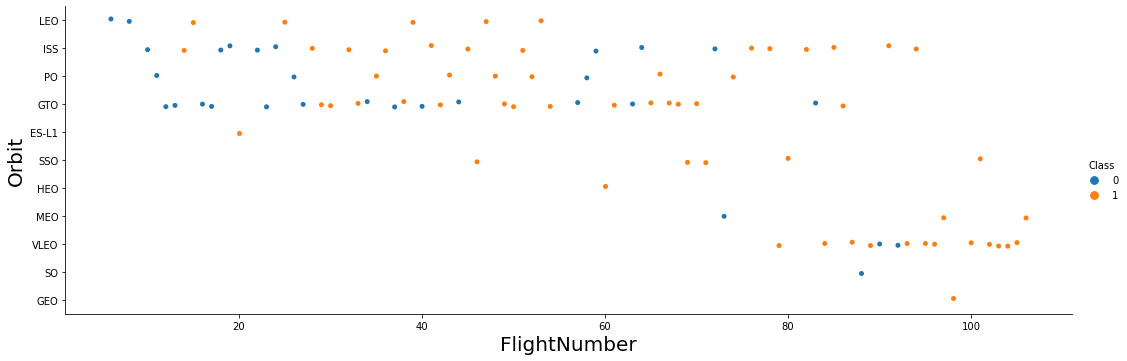

In [35]:
# scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=df, aspect = 3)
plt.xlabel("FlightNumber",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

The success rate for LEO orbit seems to be related to the number of flights. However, there seems to be no relationshib between the number of flights and success rate for GTO orbit.

### Visualize the relationship between Payload and Orbit type

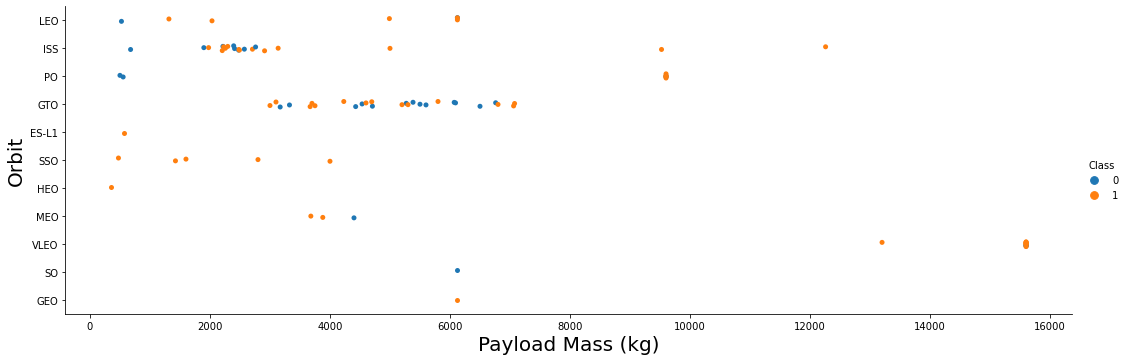

In [36]:
# scatter point chart with x axis to be Payload and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=df, aspect = 3)
plt.xlabel("Payload Mass (kg)",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

For LEO and ISS orbits, success rate seems to increase for heavy Payload Mass. However for GTO orbit there seems to be no correlation.

### Visualize the launch success yearly trend

In [37]:
# function to extract years from the date 
year=[]
def Extract_year():
    for i in df["Date"]:
        i = str(i)
        year.append(i.split("-")[0])
    return year
year = Extract_year()

df['Year'] = year
df.head()
grouped_by_year = df.groupby("Year")
mean_by_year = grouped_by_year.mean()
mean_by_year["Class"]
mean_by_year.reset_index(inplace=True)

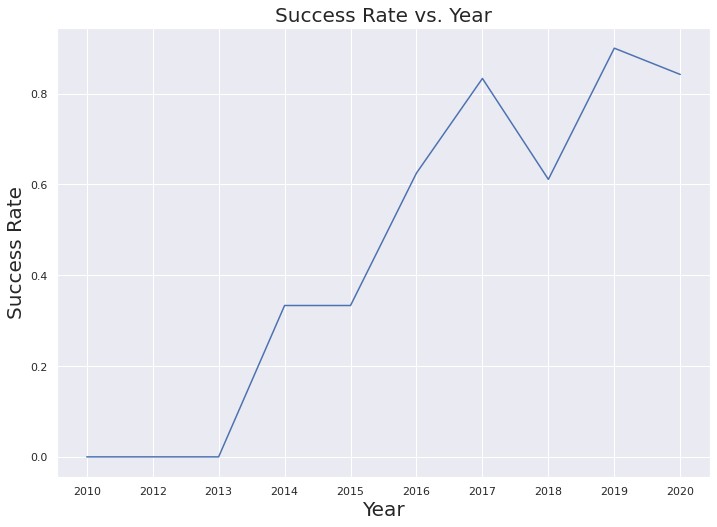

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=mean_by_year, x='Year', y='Class')
plt.xlabel("Year",fontsize=20)
plt.title('Success Rate vs. Year',fontsize=20)
plt.ylabel("Success Rate",fontsize=20)
plt.show()

The line chart show a clear upward trend of the success rate over the years.

## Features Engineering
In this section I apply One Hot Encoding technique to create dummy numerical variables from the categoriacal variables of interest.

First, I select the variables that can be useful to determine the landing likelyhood of the first stage of the missile. I store them in the list <code>features</code>.

In [39]:
# list of selected features
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,6,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,8,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,10,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,11,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,12,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


I apply One Hot Encoding to the categorical features belonging to the list <code>features</code>.

In [40]:
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])

In [41]:
# convert the data fo float type
features_one_hot = features_one_hot.astype('float64')
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,6.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,8.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,11.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,12.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Geospatial Data Visualization
The launch success rate may depend on several facotors including the location and proximities of the launch site (i.e. the initial position of rocket trajectories.

In this section the different launch site locations are displayed in a map and labeled according to the launch outcome. This will enable to explore the proximities of the launch location and to detect possible patterns that affect the launch success rate.

In [42]:
# install required libraries
!pip3 install folium
!pip3 install wget

In [43]:
# import required libraries
import folium
import wget

In [44]:
# import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# import folium MousePosition plugin
from folium.plugins import MousePosition
# import folium DivIcon plugin
from folium.features import DivIcon

ImportError: cannot import name 'MousePosition' from 'folium.plugins' (/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/folium/plugins/__init__.py)

Get the coordinates of the launch sites.

In [ ]:
# select relevant sub-columns: `Launch Site`, `Latitude`, `Longitude`, `class`
# and group by the launch site
spacex_df = df[['LaunchSite', 'Latitude', 'Longitude', 'Class']]
launch_sites_df = spacex_df.groupby(['LaunchSite'], as_index=False).first()
launch_sites_df = launch_sites_df[['LaunchSite', 'Latitude', 'Longitude']]
launch_sites_df

In [ ]:
CCSFS_SLC_40_coordinate = [launch_sites_df.at[0,'Latitude'], launch_sites_df.at[0,'Longitude']]
KSC_LC_39A_coordinate = [launch_sites_df.at[1,'Latitude'], launch_sites_df.at[1,'Longitude']]
VAFB_SLC_4E_coordinate = [launch_sites_df.at[2,'Latitude'], launch_sites_df.at[2,'Longitude']]

In [ ]:
# initial the map (folium.Map object), set NASA location as center of map
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)

# create Circle object based on its coordinate (Lat, Long) values for each launch site. Add Launch site name as a popup label
CCSFS_SLC_40_circle = folium.Circle(CCSFS_SLC_40_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('Cape Canaveral Space Launch Complex'))
KSC_LC_39A_circle = folium.Circle(KSC_LC_39A_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('Vandenberg Air Force Base Space Launch Complex 4E'))
VAFB_SLC_4E_circle = folium.Circle(VAFB_SLC_4E_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('Kennedy Space Center Launch Complex 39A'))

CCSFS_SLC_40_marker = folium.map.Marker(
    CCSFS_SLC_40_coordinate,
    # create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'CCSFS SLC 40',
        )
    )
KSC_LC_39A_marker = folium.map.Marker(
    KSC_LC_39A_coordinate,
    # create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'KSC LC 39A',
        )
    )
VAFB_SLC_4E_marker = folium.map.Marker(
    VAFB_SLC_4E_coordinate,
    # create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'VAFB SLC 4E',
        )
    )


site_map.add_child(CCSFS_SLC_40_circle)
site_map.add_child(CCSFS_SLC_40_marker)
site_map.add_child(KSC_LC_39A_circle)
site_map.add_child(KSC_LC_39A_marker)
site_map.add_child(VAFB_SLC_4E_circle)
site_map.add_child(VAFB_SLC_4E_marker)

## Mark the success/failed launches on each site
If a launch was successful (<code>Class=1</code>) I use a green marker, if a launch was failed (<code>Class=0</code>) I use a red marker.

Since many launches happen in the same location I use a marker cluster.

In [ ]:
marker_cluster = MarkerCluster()

In [ ]:
# function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['Class'].apply(assign_marker_color)
spacex_df.tail(10)

In [ ]:
# add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# create a Marker object with its coordinate for each row, indicating the oucome through the marker color
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    coordinates = [record['Latitude'], record['Longitude']]
    marker = folium.Marker(
    location=coordinates,
        
    icon=folium.Icon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        color=record['marker_color'],
        )
    )
    
    
    marker_cluster.add_child(marker)

site_map

The above chart shows the launching site of a mission through markers colored based on the langing outcome. Inside a cluster, the different locations (that have same longitude and latitude values) are shown in a spiral that have closer to the center the most remote missions.

# Machine Learning Prediction
In this section I will create a machine learning pipeline to predict if the first stage of the Falcon 9 rocket lands successfully.
The pipeline will include:
- preprocessing
- train & test split
- grid search

Preprocessing allows to standardize the data. Train & Test split allows to divide the dataset into two subsets, one for the training process and the other one for the testing and validation process.
I will perform Grid Search in order to find the hyperparameters that guarantee the best performance of the chosen algorithm.
The algorithms that will be tested are:
- Logistic Regression
- Support Vector Machine
- Decision Tree Classifier
- K-Nearest Neighbors

In [56]:
# import required libraries
# preprocessing allows us to standarsize our data
from sklearn import preprocessing
# allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# support Vector Machine classification algorithm
from sklearn.svm import SVC
# decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# k Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [57]:
# function to plot the confusion matrix
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    # import library
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Did Not Land', 'Land']); ax.yaxis.set_ticklabels(['Did Not Land', 'Landed'])

## Preprocessing

In [58]:
# define independent and dependent variables
X = features_one_hot
Y = df['Class'].to_numpy()

In [59]:
# standardize the data in X
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

## Train & Test Split

In [60]:
# perform the division in 4 subsets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [61]:
#see the size of test data
Y_test.shape

(18,)

## Logistic Regression
Documentation for chosen parameters: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html" target="_blank">sklearn.linear_model.LogisticRegression</a>.

### Parameters Definition
I define the parameters (or set of parameters) for Logistic Regression as follows:

In [62]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

### Model Fitting and Selection of Best Parameters

In [63]:
# create LogisticRegression object
lr=LogisticRegression()
# create GridSearchCV object taking as input the parameters sets, the model and the number of folds for cross validation (here cv is set to 10)
gscv = GridSearchCV(lr,parameters,scoring='accuracy',cv=10)
# fit the Logistic Regression model with the training data
logreg_cv = gscv.fit(X_train,Y_train)

In [64]:
print("Tuned Hpyerparameters for Logistic Regression: ",logreg_cv.best_params_)
print("Accuracy :",logreg_cv.best_score_)

Tuned Hpyerparameters for Logistic Regression:  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8194444444444444


### Validation of the Model
Here I compute the accuracy of the model using the testing dataset.

In [65]:
print('Logistic Regression Model Accuracy = ',logreg_cv.score(X_test,Y_test))

Logistic Regression Model Accuracy =  0.8333333333333334


### Confusion Matrix

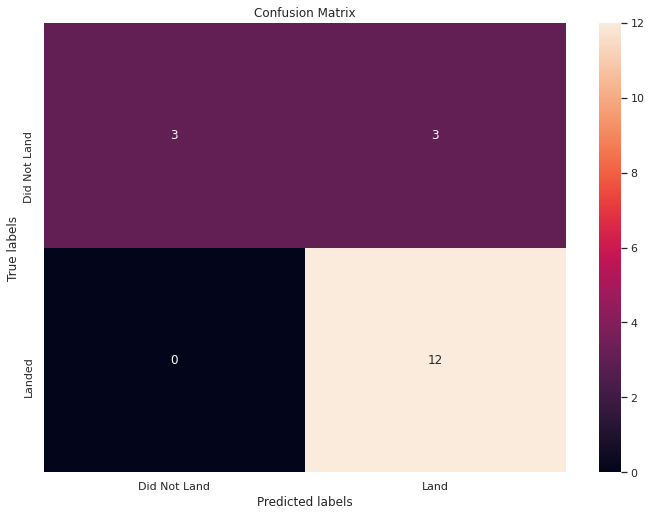

In [66]:
# predict outcome with test data
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

From the Confusion Matrix it's possible to see how the model is able to predict the outcome in most of the cases:
- all the landed flights were predicted correctly
- 3 / 6 failed flights were predicted correctly
- 3 / 6 failed flights were predicted incorrectly

The Confusion Matrix shows that the main problem with the algorithm are False Positives.

## Support Vector Machine
Documentation for chosen parameters: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html" target="_blank">sklearn.svm.SVC</a>.

### Parameters Definition
I define the parameters (or set of parameters) for SVM as follows:

In [67]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}

### Model Fitting and Selection of Best Parameters

In [68]:
# create SVM object
svm = SVC()
# create GridSearchCV object taking as input the parameters sets, the model and the number of folds for cross validation (here cv is set to 10)
gscv = GridSearchCV(svm,parameters,scoring='accuracy',cv=10)
# fit the SVM model with the training data
svm_cv = gscv.fit(X_train,Y_train)

In [69]:
print("Tuned Hpyerparameters for Support Vector Machine: ",svm_cv.best_params_)
print("Accuracy :",svm_cv.best_score_)

Tuned Hpyerparameters for Support Vector Machine:  {'C': 0.03162277660168379, 'gamma': 0.001, 'kernel': 'linear'}
Accuracy : 0.8333333333333334


### Validation of the Model
Here I compute the accuracy of the model using the testing dataset.

In [70]:
print('Support Vector Machine Model Accuracy = ',svm_cv.score(X_test,Y_test))

Support Vector Machine Model Accuracy =  0.8333333333333334


### Confusion Matrix

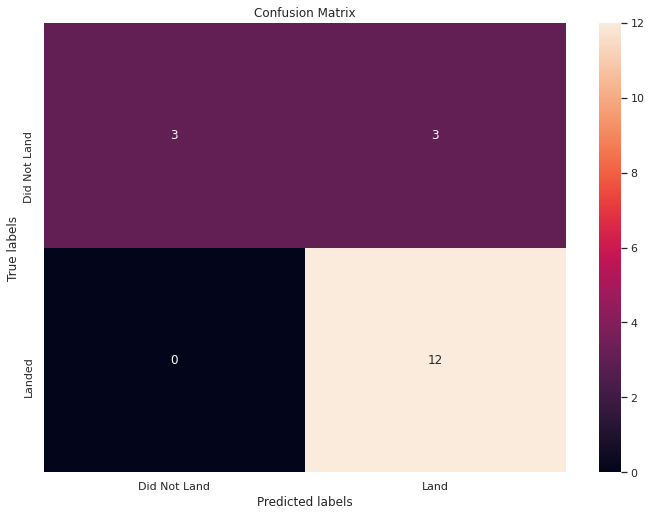

In [71]:
# predict outcome with test data
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Decision Tree Classifier
Documentation for chosen parameters: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html" target="_blank">sklearn.tree.DecisionTreeClassifier</a>.

### Parameters Definition
I define the parameters (or set of parameters) for Decision Tree Classifier as follows:

In [80]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

### Model Fitting and Selection of Best Parameters

In [81]:
# reset random seed
np.random.seed(0)
# create DecisionTreeClassifier object
tree = DecisionTreeClassifier()
# create GridSearchCV object taking as input the parameters sets, the model and the number of folds for cross validation (here cv is set to 10)
gscv = GridSearchCV(tree,parameters,scoring='accuracy',cv=10)
# fit the DecisionTreeClassifier model with the training data
tree_cv = gscv.fit(X_train,Y_train)


In [82]:
print("Tuned Hpyerparameters for Decision Tree Classifier: ",tree_cv.best_params_)
print("Accuracy :",tree_cv.best_score_)

Tuned Hpyerparameters for Decision Tree Classifier:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy : 0.875


### Validation of the Model
Here I compute the accuracy of the model using the testing dataset.

In [83]:
print('Decision Tree Classifier Machine Model Accuracy = ',tree_cv.score(X_test,Y_test))

Decision Tree Classifier Machine Model Accuracy =  0.8333333333333334


### Confusion Matrix

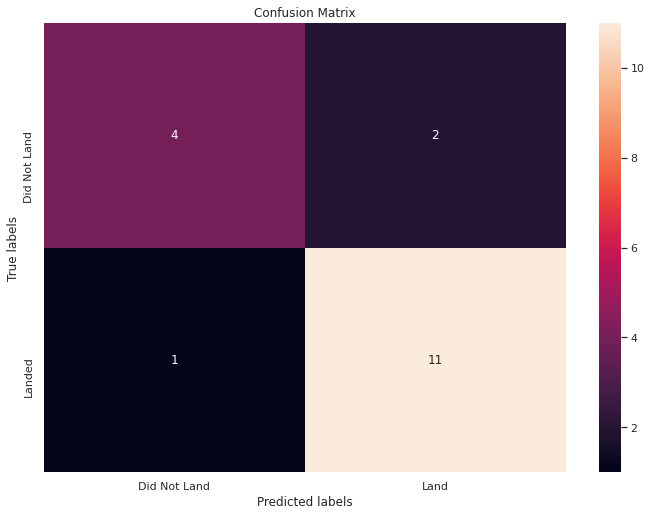

In [84]:
# predict outcome with test data
yhat=tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## K-Nearest Neighbors
Documentation for chosen parameters: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html" target="_blank">sklearn.neighbors.KNeighborsClassifier</a>.

### Parameters Definition
I define the parameters (or set of parameters) for K-Nearest Neighbors as follows:

In [85]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

### Model Fitting and Selection of Best Parameters

In [97]:
# reset random seed
np.random.seed(0)
# create KNeighborsClassifier object
KNN = KNeighborsClassifier()
# create GridSearchCV object taking as input the parameters sets, the model and the number of folds for cross validation (here cv is set to 10)
gscv = GridSearchCV(KNN,parameters,scoring='accuracy',cv=10)
# fit the KNeighborsClassifier model with the training data
knn_cv = gscv.fit(X_train,Y_train)

In [98]:
print("Tuned Hpyerparameters for K-Nearest Neighbors: ",knn_cv.best_params_)
print("Accuracy :",knn_cv.best_score_)

Tuned Hpyerparameters for K-Nearest Neighbors:  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
Accuracy : 0.8333333333333334


### Validation of the Model
Here I compute the accuracy of the model using the testing dataset.

In [99]:
print('Decision Tree Classifier Machine Model Accuracy = ',knn_cv.score(X_test,Y_test))

Decision Tree Classifier Machine Model Accuracy =  0.7777777777777778


### Confusion Matrix

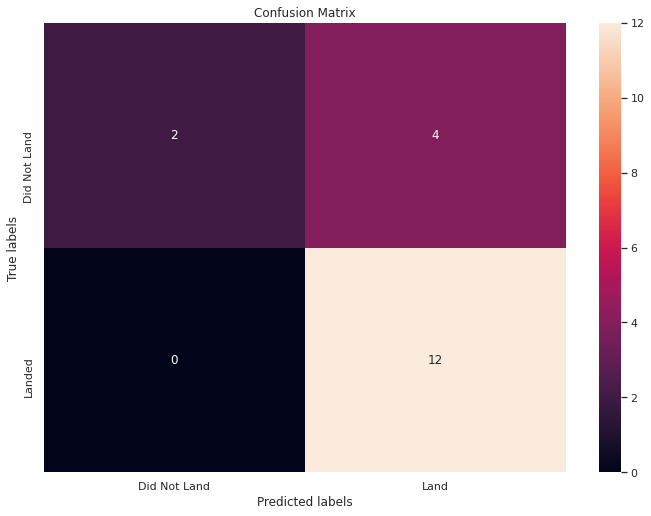

In [88]:
yhat=knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Find the Best Model
Here I compare the scores obtained by the different models in order to chose the best one.

In [95]:
algorithms = {'KNN':knn_cv.best_score_,'Tree':tree_cv.best_score_,'LogisticRegression':logreg_cv.best_score_, 'SVM':svm_cv.best_score_}
bestAlgorithm = max(algorithms)
print('The best algorithm is',bestAlgorithm,'with a score of',algorithms[bestAlgorithm])
if bestAlgorithm == 'Tree':
    print('The best parameters are :',tree_cv.best_params_)
if bestAlgorithm == 'KNN':
    print('The best parameters are :',knn_cv.best_params_)
if bestAlgorithm == 'LogisticRegression':
    print('The best parameters are :',logreg_cv.best_params_)
if bestAlgorithm == 'SVM':
    print('The best parameters are :',svm_cv.best_params_)

The best algorithm is Tree with a score of 0.875
The best parameters are : {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


The Decision Tree Classifier appears to have a slightly higher score (computed with the method <code>.best_score_</code>) than the other methods. Nevertheless, the scores computed with the method <code>.score()</code> is practically the same for every algorithm.

I conclude that there is not a significant difference between the performances of the different algorithms when Grid Search is performed.

# <a name="conclusions"> Conclusions </a>

The aim of this project was to develop a Machine Learning model to predict the fair price of a car given its characteristics. 

Different steps have been performed in order to clean the original dataset and to isolate the most significant variables. In fact, many of the independent variables were not correlated with the target variable "price".

Finally, different Machine Learning models were developed and tested through both visualization and numerical evaluation methods. Ultimately, a Ridge Regression model with the parameter "alpha" of value 1,000 was selected as the most suitable model for determining the car price given the car's characteristics.